In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS" & physeq.Bulk.m$Month %in% c("April", "November")),
                           physeq.Bulk)

physeq.Bulk = subset_taxa(physeq.Bulk, Rank1=="k__Fungi")
physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq/ITS//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2247 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2247 taxa by 7 taxonomic ranks ]


In [5]:
%%R
get_l2fc = function(physeq.obj, Land_Management, sparsity_threshold) {
  
    physeq.Bulk.m = physeq.obj %>% sample_data

    p = prune_samples((physeq.Bulk.m$Land_Management == Land_Management),
                           physeq.Bulk)
   
    
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Month)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}
                    
                  

In [6]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Land_Management) %>%
   distinct() %>%
    arrange(Land_Management) 
  

sdm

  Land_Management
1             NTH
2             NTR
3             PTH
4             PTR


In [7]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Land_Management'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 76 

  Land_Management sparsity_threshold
1             NTH               0.05
2             NTR               0.05
3             PTH               0.05
4             PTR               0.05
5             NTH               0.10
6             NTR               0.10


In [8]:
%%R
#For testing method
test = head(sdms, 5)
test

  Land_Management sparsity_threshold
1             NTH               0.05
2             NTR               0.05
3             PTH               0.05
4             PTR               0.05
5             NTH               0.10


In [9]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [16,677 x 13]

   Land_Management sparsity_threshold       OTU log2FoldChange    lfcSE
             (chr)              (dbl)     (chr)          (dbl)    (dbl)
1              NTH               0.05  OTU.6089     -3.6559483 2.048903
2              NTH               0.05  OTU.2605     -1.8119042 1.875525
3              NTH               0.05 OTU.21439      1.4294952 2.033000
4              NTH               0.05 OTU.17326      2.1019132 2.110536
5              NTH               0.05 OTU.14908     -1.3921759 1.992522
6              NTH               0.05  OTU.6041      1.3870584 2.003298
7              NTH               0.05 OTU.38654      1.4800435 2.112999
8              NTH               0.05  OTU.6291      0.1944289 1.923281
9              NTH               0.05  OTU.9364     -0.6291622 1.803921
10             NTH               0.05   OTU.586     -0.1565847 1.969959
..             ...                ...       ...            ...      ...
Variables not shown: pad

In [10]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   meanl2fc
      (dbl)
1 0.5620666


In [11]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 1.871732


In [12]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [13]:
%%R
levels(physeq.Bulk.m$Month)

[1] "April"    "November"


In [14]:
%%R
df.l2fc$Month[df.l2fc$log2FoldChange < 0] = "April"
df.l2fc$Month[df.l2fc$log2FoldChange > 0] = "November"

In [15]:
%%R
write.table(df.l2fc, "data/l2fc_AprilvsNov_all", row.names = FALSE, sep = ",")

In [16]:
%%R
df.l2fc = read.table("data/l2fc_AprilvsNov_all", header = TRUE, sep = ",")

In [17]:
%%R
tail(df.l2fc)

      Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
16672             PTR               0.95 OTU.82503      0.6362705 0.6374154
16673             PTR               0.95   OTU.388      1.1199050 0.6957551
16674             PTR               0.95   OTU.157      1.1602610 0.5891453
16675             PTR               0.95   OTU.549      0.2467255 0.6166610
16676             PTR               0.95 OTU.37716      2.7910410 0.6715595
16677             PTR               0.95   OTU.102     -0.4721980 0.7319665
             padj    Rank1            Rank2              Rank3           Rank4
16672 0.832880192 k__Fungi    p__Ascomycota c__Sordariomycetes  o__Hypocreales
16673 0.598423117 k__Fungi    p__Ascomycota               <NA>            <NA>
16674 0.440167684 k__Fungi    p__Ascomycota    c__unidentified o__unidentified
16675 0.855414034 k__Fungi p__Basidiomycota c__Tremellomycetes o__unidentified
16676 0.001165624 k__Fungi    p__Ascomycota c__Dothideomycetes           

In [18]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05             4
2               0.10             5
3               0.15             5
4               0.20             5
5               0.25             5
6               0.30             5


In [19]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

  sparsity_threshold n_reject_hypo
1               0.05             4
2               0.10             5
3               0.15             5


In [20]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.35


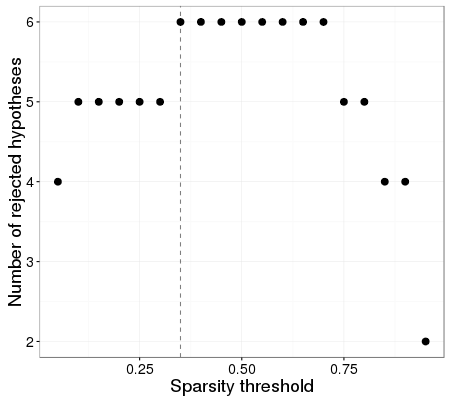

In [21]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [22]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 831


In [23]:
%%R
head(df.l2fc.f)

  Land_Management sparsity_threshold      OTU log2FoldChange     lfcSE
1             NTH               0.35 OTU.1470    -1.29318808 1.1126845
2             NTH               0.35 OTU.5914     0.28924332 1.1489257
3             NTH               0.35  OTU.133    -0.87474580 0.6549149
4             NTH               0.35   OTU.45    -0.03553787 0.6013082
5             NTH               0.35 OTU.2583    -0.88649111 1.1450653
6             NTH               0.35 OTU.3002     0.07886558 1.2214179
       padj    Rank1            Rank2              Rank3           Rank4
1 0.6622789 k__Fungi p__Basidiomycota  c__Agaricomycetes   o__Agaricales
2 0.9699355 k__Fungi  p__unidentified    c__unidentified o__unidentified
3 0.5407220 k__Fungi    p__Ascomycota c__Sordariomycetes  o__Hypocreales
4 0.9859889 k__Fungi p__Basidiomycota  c__Agaricomycetes  o__Polyporales
5 0.7895758 k__Fungi p__Basidiomycota  c__Agaricomycetes   o__Agaricales
6 0.9859889 k__Fungi p__Basidiomycota  c__Agaricomycetes   o__Aga

In [24]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_AprilvsNov.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_AprilvsNov.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [25]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_AprilvsNov.txt', sep='\t', header = TRUE)

In [26]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub('__', "", df.l2fc$Rank7)

####Function arguments

In [27]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Month, Land_Management) %>% summarise(resp = n())
resp %>% as.data.frame

     Month Land_Management resp
1 November             NTH    3
2 November             NTR    2
3 November             PTH    1


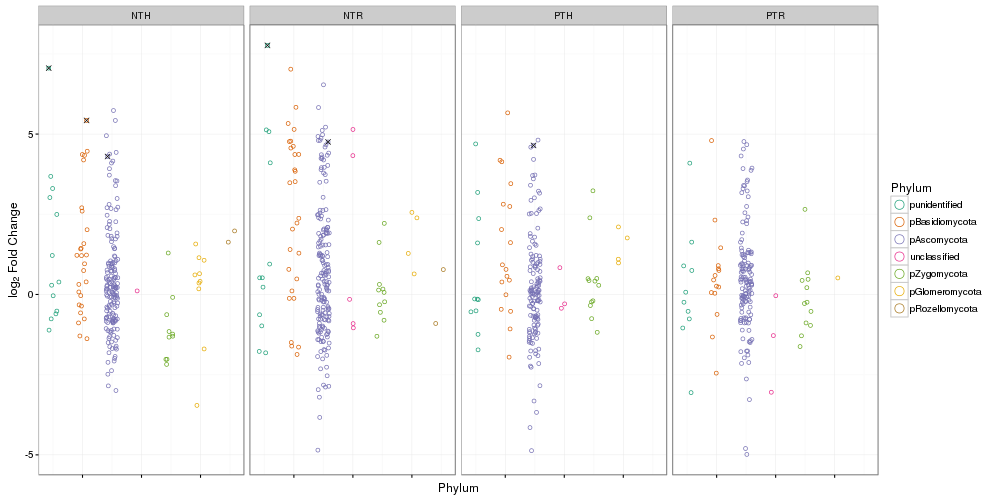

In [28]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

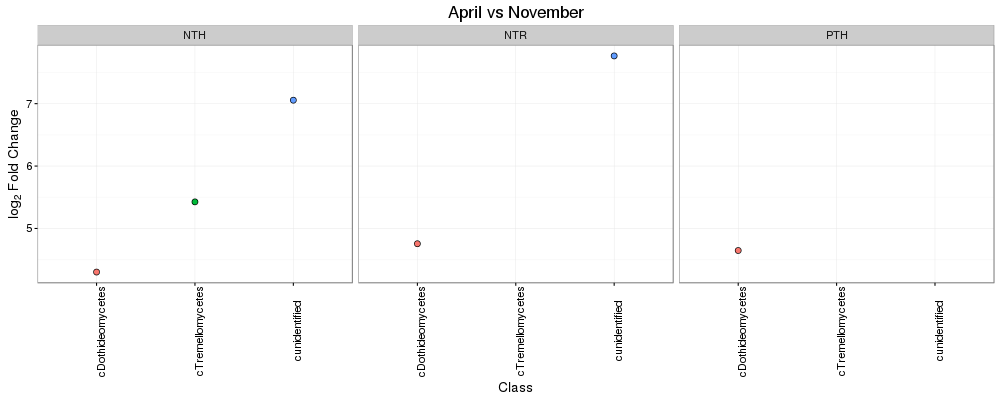

In [29]:
%%R -w 1000 -h 400
d = df.l2fc

d = filter(d, padj2 <=0.10)
FDR = 0.10

d$Rank2 = as.character(d$Rank3)
d$Rank2[is.na(d$Rank3)] = "unclassified"
d$Rank2 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = Rank3, y = log2FoldChange, fill = Rank3))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 2.5)

p = p + scale_color_manual(values = getPalette(colourCount))

#p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4))) +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) +
        guides(fill = FALSE) + ggtitle('April vs November')


p